# 7.프로젝트: 뉴스기사 요약해보기
##### !. Google Colab에서 작성되었습니다.


---

### (본문)

### STEP 0: 주요 라이브러리 import

In [43]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from importlib_metadata import version
import nltk
nltk.download('stopwords')
import tensorflow
import summa

print(nltk.__version__) # version 3.2.5
print(tensorflow.__version__) # version 2.8.0
print(version('summa')) # version 1.2.0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
3.2.5
2.8.0
1.2.0


In [45]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup 
import os
from sklearn.model_selection import train_test_split
import urllib.request
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences




### STEP 1: 데이터 수집하기

사용 데이터 - news_summary_more.csv  
출처: https://github.com/sunnysai12345/News_Summary

In [4]:
# 아래의 코드로 데이터 다운로드.
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [5]:
data.sample(10)


,headlines,text
97039,80% of former MPs are crorepatis: Supreme Court,The Supreme Court has saidÃ¢ÂÂ nearly 80% of...
64332,Samsung gives free Galaxy Note 8 to 200 passen...,Samsung Spain has distributed its Galaxy Note ...
9641,BCCI advises Bengal to let Shami bowl only 15 ...,The BCCI has asked Bengal to let Mohammad Sham...
33093,Singapore airport tests face recognition to fi...,Singapore's Changi airport has been testing fa...
94043,Death penalties in India increased by 81% in 2...,India has registered an 81% increase in death ...
12781,RBI Governor Urjit Patel cited lower inflation...,Reserve Bank of India Governor Urjit Patel cit...
74695,Below my dignity to respond to board's allegat...,Infosys Co-founder NR Narayana Murthy in a let...
89162,Sense of smell in humans just as good as dogs:...,A US-based study claims the human sense of sme...
55183,US foolishly spent $7 trillion in Middle East:...,US President Donald Trump has said that the US...
88217,ICJ didn't order consular access to Jadhav: Pa...,Pakistan's foreign affairs adviser Sartaj Aziz...


이 데이터는 기사의 본문에 해당하는 text와 headlines 두 가지 열로 구성되어져 있음.  
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습.  
추출적 요약을 하는 경우에는 오직 text열만을 사용.

### STEP 2: 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해보기.  
만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것에대해서도 고민.  

데이터 전처리의 단계는 총 3단계로 나누어짐  
1. 데이터 정리하기  
2. 훈련데이터와 테스트데이터 나누기  
3. 정수 인코딩   

#### 2-1 데이터 정리하기

중복 샘플 및 Null 값이 존재하는 샘플 제거

In [6]:
# 데이터의 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


데이터의 Null 값이 있는 확인하기 위해 .isnull().sum()를 사용

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


이 데이터에서는 결측치는 존재하지 않음.

In [9]:
# 데이터프레임에서 Null을 제거할 때 dropna() 함수 사용
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 : ', (len(data)))

##### 텍스트와 정규화와 불용어 제거

텍스트 정규화(test normalization): it'll = it wll처럼 같은 의미의 표현들을 통일시키는 과정.  
기계학습 전에 텍스트 정규화를 통해 기계의 연산량을 줄일 수 있음.
여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성.

정규화 사전 출처: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어: 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들.  
불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법이 될 수도 있음.  
여기서는 NLTK에서 제공하는 불용어 리스트를 참조, 샘플에서 불용어를 제거.


In [11]:
# from nltk.corpus import stopwords
# nltk.download('stopwords')
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개.  
이를 사용하여 불용어 제거.  
모든 영어 문자는 소문자로.  
섞여있는 html 태그 제거.  
정규 포현식을 통해 각종 특수문자를 제거.  


함수의 하단에는 NLTK를 이용해 불용어를 제거하는 파트가 있음.  
이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정.   
Abstractive한 문자 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는게 더 좋음.  
이 처리를 위해 함수의 인자로 remove_stopwords를 추가하고, if문을 추가

In [12]:
# import re
# from bs4 import BeautifulSoup 
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('NLTK를 이용한 불용어 제거 수행')

NLTK를 이용한 불용어 제거 수행


훈련 데이터 전체에 대해서 전처리를 수행.  
text는 불용어를 제거  
headlines는 불용어를 제거하지 않으므로 따로 호출해서 진행.  
멀티프로세싱을 활용하여 별도의 프로세스를 생성, 병렬처리로 소요시간을 단축하여 진행.

In [13]:
import multiprocessing as mp  
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 함

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) 
print(clean_headlines)


261.3860514163971  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

정제 전 데이터가 존재했었지지만 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있음. 샘플 자체가 빈값을 가짐.  
데이터를 확인하기 위한 데이터프레임 사용.  
이후 empty 값을 가진 샘플들이 있다면, 모두 null 값을 가진 샘플로 대체

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

#### 2-2. 훈련 데이터와 테스트 데이터 분할


샘플의 최대 길이 정하기  
text 와 headlines의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화

text 의 최소 길이 : 1
text 의 최대 길이 : 60
text 의 평균 길이 : 35.09968483123221
headlines 의 최소 길이 : 1
headlines 의 최대 길이 : 16
headlines 의 평균 길이 : 9.299532330215534


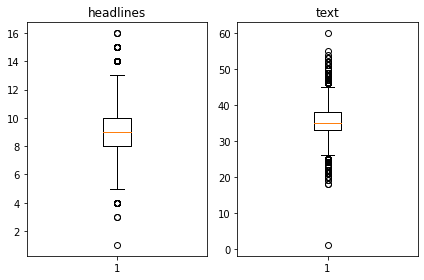

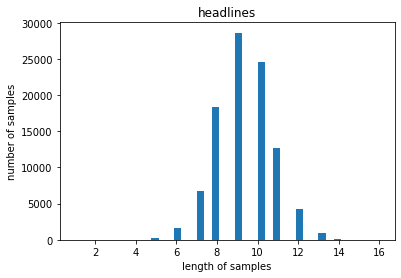

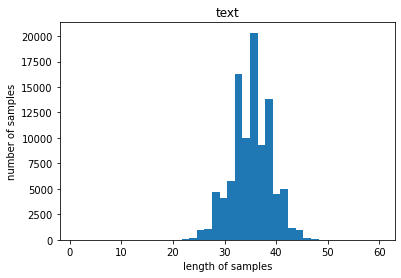

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text 의 최소 길이 : {}'.format(np.min(text_len)))
print('text 의 최대 길이 : {}'.format(np.max(text_len)))
print('text 의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines 의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines 의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines 의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

그래프의 의미  
(1)Summary과 실제 Text의 길이 분포  
(2) 요약본 샘플 길이별 개수  
(3) 실제 텍스트 샘플 길이별 개수  

text와 headlines 모두 정규 분포 곡선과 비슷한 형태로 데이터가 분포하는 것을 알 수 있음.  
따라서 text와 headlines의 최대 길이는 모든 데이터가 포함 될 수 있도록 지정.

In [16]:
text_max_len = 60
headlines_max_len = 16

In [17]:
def below_threshold_len(max_len, nested_list):  # 데이터의 몇 %가 해당하는지 계산하는 함수
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])


전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


#### 시작 토큰과 종료 토큰 추가

seq2seq 훈련을 위해서 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가.  
시작토큰은 sostoken, 종료 토큰은 eostoken이라 임의 명명, 앞,뒤로 추가.  

In [18]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [19]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장 

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 훈련 데이터와 테스트 데이터 분할  
sklearn.model_selection의 train_test_split을 사용해 훈련 데이터와 테스트 데이터를 분할.  
이때 test_size 값은 0.2로 지정.  
또한 결과를 일정하게 보여주기 위해 random_state 값은 34로 지정.  

In [20]:
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input,
                                                                                                                                               decoder_input,
                                                                                                                                               decoder_target,
                                                                                                                                               test_size=0.2,                                   
                                                                                                                                               random_state=34)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


#### 2-3. 정수인코딩

#### 단어 집합(vocablulary) 만들기 및 정수 인코딩

Keras의 토크나이저를 사용해서 입력된 훈련 데이터로부터 단어 집합 만들기.

In [21]:
#from tensorflow.keras.preprocessing.text import Tokenizer 
src_tokenizer = Tokenizer() # 토큰나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있음.  
만든 단어 집합에 있는 모든 단어를 사용하는 것이 아닌, 빈도수가 낮은 단어들은 훈련 데이터에서 제외.  
src_tokenizer.word_counts.items()를 사용하여 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인.

In [22]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 69618
등장 빈도가 7번 이하인 희귀 단어의 수: 48939
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20679
단어 집합에서 희귀 단어의 비율: 70.29647504955615
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.856952677557366


등장 빈도가 thershold 값인 8회 미만, 즉 7회 이하인 단어들은 단어 집합에서 @@%를 차지.  
but, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.8%밖에 되지 않음.  

등장 빈도가 7회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거.  
위에서 이를 제외한 단어 집합의 크기를 2만여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 @@@@으로 제한.

In [23]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [24]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[0])

[1833, 919, 237, 1, 339, 9681, 1037, 3044, 231, 11884, 9152, 2916, 4000, 856, 4467, 200, 1515, 7671, 6477, 1085, 6, 4, 919, 1, 11573, 14794, 9488, 559, 431, 861]


##### headlines 데이터에 대해서도 동일한 작업 수행

In [25]:
# 전체 단어 집합과 각 단어에 대한 빈도수를 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [26]:
# 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 30026
등장 빈도가 6번 이하인 희귀 단어의 수: 20509
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9517
단어 집합에서 희귀 단어의 비율: 68.30413641510691
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.292321359169396


In [27]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[0])
print('target')
print('decoder ',decoder_target_train[0])

input
input  [1, 142, 10, 636, 8784, 16, 1481, 522, 526]
target
decoder  [142, 10, 636, 8784, 16, 1481, 522, 526, 2]


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 empty 샘플이 되었을 가능성이 있음.  
decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이므로 길이가 0이 된 요약문의 실제 길이는 1로 나올 것.  
훈련 데이터와 테스트 데이터에 대해서 요약문의 기링가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하고 샘플들은 모두 삭제.  

In [28]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


##### 패딩 추가
최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 아까 정해두었던 최대 길이로 길이를 맞춤.

In [30]:
#from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')


### STEP 3: 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있음. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계.

#### seq2seq 설계  
함수형 API를 이용해 인코더 설계

In [32]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

인코더의 LSTM은 총 3개의 층으로 구성 모델의 복잡도를 높임(모델의 용량을 늘림).  
 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줌

In [33]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


In [34]:
# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

#### 어텐션 메커니즘

In [39]:
!pip install attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻.  
여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 확인.  
여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션

In [51]:
from tensorflow.keras.layers import AdditiveAttention


In [53]:

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

#### 모델 훈련

설계한 모델을 가지고 훈련을 진행

In [54]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 261s 809ms/step - loss: 4.2193 - val_loss: 3.8644
Epoch 2/50
308/308 [==============================] - 248s 806ms/step - loss: 3.7310 - val_loss: 3.5661
Epoch 3/50
308/308 [==============================] - 249s 808ms/step - loss: 3.4813 - val_loss: 3.3717
Epoch 4/50
308/308 [==============================] - 249s 807ms/step - loss: 3.2968 - val_loss: 3.2438
Epoch 5/50
308/308 [==============================] - 249s 809ms/step - loss: 3.1463 - val_loss: 3.1351
Epoch 6/50
308/308 [==============================] - 248s 805ms/step - loss: 3.0200 - val_loss: 3.0537
Epoch 7/50
308/308 [==============================] - 247s 802ms/step - loss: 2.9107 - val_loss: 2.9775
Epoch 8/50
308/308 [==============================] - 247s 801ms/step - loss: 2.8182 - val_loss: 2.9207
Epoch 9/50
308/308 [==============================] - 246s 800ms/step - loss: 2.7376 - val_loss: 2.8782
Epoch 10/50
308/308 [==============================] - 247s 801m

조기 종료를'를 뜻하는 earlyStopping 은 특종 조건이 충족되면 훈련을 멈추는 역할을 함.
위 코드에서는 val_los(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정.  

아래는 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 함.


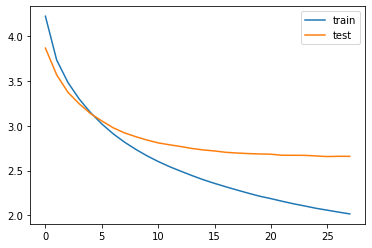

In [55]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 인퍼런스 모델 구현

In [56]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [57]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어테션 메커니즘을 사용하는 출력층 설계

In [59]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('어텐션 메커니즘을 사용하는 출력층 설계완료')

어텐션 메커니즘을 사용하는 출력층 설계완료


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만듬.

In [60]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### STEP 4: 실제 결과와 요약문 비하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교.

#### 모델 테스트  

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만듬.  
이때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 함.  

In [61]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터의 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교.

In [62]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former indian navy officer kulbhushan jadhav mother called ki maa pakistan media outside country foreign office islamabad meeting son monday jadhav mother wife forced wait car heckled journalists jadhav sentenced death pakistan military court 
실제 요약 : pakistan media calls jadhav mother ki maa 
예측 요약 :  kulbhushan jadhav mother mother of kulbhushan jadhav


원문 : second odi india windies visakhapatnam wednesday ended last ball tie teams scored runs india second tied odi month tie afghanistan september tie india extended unbeaten run across formats international cricket matches 
실제 요약 : nd india wi odi ends in tie india nd tied odi in month 
예측 요약 :  india beat sl by runs to take lead in odi series


원문 : india anti doping body national anti doping agency reportedly conducted tests intended target tests throughout tests conducted april december notably india ranked third global anti doping violation figures 
실제 요약 : conducted tests out of target of 
예측 요약 :  india to be banned from d

### STEP 5: Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해 난이도가 높음.
반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮음.  
summa의 summarize를 사용하여 추출적 요약 실행.

#### 추출적 요약 (Extractive Summarization)


패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 구현할 수 있음.

In [63]:
from summa.summarizer import summarize
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [64]:
data.sample(10)


,headlines,text
2221,Civil surgeon kisses woman in operation theatr...,A 49-year-old civil surgeon from Ujjain distri...
19110,Priyanka's future father-in-law's firm files f...,Priyanka Chopra's future father-in-law Paul Jo...
78409,Many refused Toilet- Ek Prem Katha before I go...,Actor Akshay Kumar has revealed that before he...
75347,Lanka side will struggle against any Ranji tea...,Following India's first-ever 3-0 away whitewas...
65982,Rohingyas have no legal claim on our soil: Mya...,Rohingya Muslims were moved into Myanmar from ...
57256,Designer makes scarf inspired by iPhone X,Germany-based designer Ceyhun GÃÂ¼ney has mad...
88630,India to tour West Indies after Champions Trop...,BCCI has announced the fixtures of India's tou...
9072,US couple finds Ã¢ÂÂ¹12.8cr winning lottery t...,A US couple found a $1.8-million (Ã¢ÂÂ¹12.8 c...
42562,BJP minister meets Opposition leaders over Par...,BJP minister Vijay Goel on Thursday visited Co...
4652,Martial law ends in Ukraine amid tensions with...,Ukrainian President Petro Poroshenko announced...


summarize 를 사용한 추출적 요약

In [65]:
data['headlines_predict'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [66]:
data.sample(10)

,headlines,text,headlines_predict
13352,Self-styled godman Rampal gets life imprisonme...,Self-styled godman Rampal was on Tuesday award...,The cases were filed after his supporters clas...
29241,"Watson takes 10 balls to hit 1st run, slams 51...","CSK's Shane Watson, who took 10 balls to open ...",The 36-year-old became the first overseas play...
1452,"Aditya, Disha to star in Mohit Suri directoria...",Actors Aditya Roy Kapur and Disha Patani will ...,Actors Aditya Roy Kapur and Disha Patani will ...
48947,Delhi to scrap vehicles older than 15 years fr...,The Delhi government has proposed a policy und...,"Under the policy, such vehicles parked in publ..."
22605,Missing your company bhai: Kuldeep replies to ...,India's ODI vice-captain Rohit Sharma commente...,India's ODI vice-captain Rohit Sharma commente...
6871,Don't think umpires check for front-foot no-ba...,Ex-Australia captain Ricky Ponting has said he...,"""Part of umpiring is to get the no-ball decisi..."
13557,Apple using backpacks to collect map data on f...,Apple has assigned workers to carry backpacks ...,Apple has assigned workers to carry backpacks ...
1017,Longest Test innings was longer than 10 footba...,Former Pakistani cricketer Hanif Mohammad batt...,The 337-run knock helped Pakistan draw the match.
65652,Oscar-winning sound designer Pookutty to make ...,"Sound designer Resul Pookutty, who won the Osc...",Pookutty will be seen playing himself in the f...
62368,Examining my own behaviour: Affleck on sexual ...,"Actor Ben Affleck, while speaking on the sexua...","Actor Ben Affleck, while speaking on the sexua..."


#### 중복 샘플과 Null 값이 존재하는 샘플 제거.

In [67]:
# 데이터의 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [68]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [69]:
print(data.isnull().sum())


headlines            0
text                 0
headlines_predict    0
dtype: int64


In [70]:
for i in range(50, 100):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("예측 요약 :", data['headlines_predict'][i])
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

---

### 루브릭.

|평가문항|비고|상세기준|비고 |
|:---|:---:|:---|---:|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. | |분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다. | |
| 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.| | 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.| |
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. | |두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다. | |

---

### 회고록.

긴 문장을 짧게 요약해 주는 텍스트 요약기를 직접  Abstractive모델을 구성하기 위한 텍스트 전처리와 요약모델을 만들어 attention이나 summa등을 사용해 두가지 요약결과를 출력해보는 일곱번째 exploration이었다.  




### 추상적 요약 결과
원문 : North Korea is "unlikely to completely give up its nuclear weapons and production capabilities", Director of US' National Intelligence, Daniel Coats, said. "North Korean leaders view nuclear arms as critical to regime survival," he added. His statements come despite North Korea's agreement with the US at the Singapore summit last year to denuclearise the Korean Peninsula. 

실제 요약 : N Korea unlikely to give up nuclear weapons: US intelligence chief

예측 요약 : "North Korean leaders view nuclear arms as critical to regime survival," he added.
  


원문 : Prime Minister Narendra Modi stopped his speech at the inauguration of the new terminal building at Surat airport after observing that a cameraman had fainted. PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman. "It's good that PM was paying attention to his surroundings during his speech," the cameraman later said from a hospital. 

실제 요약 : PM Modi stops speech after cameraman faints, asks officers to help

예측 요약 : PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman.

원문 : Actress Sushmita Sen took to Instagram to share a joke on the subject of marriage. "Whoever invented marriage was creepy as hell. Like I love you so much IÃ¢ÂÂm gonna get the government involved so you canÃ¢ÂÂt leave," Sushmita's post read. "This is an insult to [the] beauty of marriage," an Instagram user commented on her post.

실제 요약 : Whoever invented marriage was creepy as hell: Sushmita posts joke

예측 요약 : Actress Sushmita Sen took to Instagram to share a joke on the subject of marriage.
"This is an insult to [the] beauty of marriage," an Instagram user commented on her post.




추상적 요약의 예측결과는 대부분 말하려는 흐름이 실려있는 경우가 많았다. 그러나 중간중간 요약이 적절하지 않은 경우(중요 단어가 없다는 둥) 가 있어 원문을 읽지 않으면 중요한 내용을 알기 힘든 경우가 있다.

### 추출적 요약 결과  
원문 : Actress Vaani Kapoor said that trolling has become a norm on social media, adding, "There's no one who hasn't got trolled on social media." "Everybody is out there to pull the other person down but it'll only bother [you] if you let it bother you," Vaani added. She further said, social media offers a platform "where people enjoy belittling everybody". 

실제 요약 : Trolling has become the norm on social media: Vaani

예측 요약 : Actress Vaani Kapoor said that trolling has become a norm on social media, adding, "There's no one who hasn't got trolled on social media." "Everybody is out there to pull the other person down but it'll only bother [you] if you let it bother you," Vaani added.

원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018. 

실제 요약 : Boeing sales cross $100bn for 1st time in its 102-yr history

예측 요약 : Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018.


원문 : Actress Sushmita Sen took to Instagram to share a joke on the subject of marriage. "Whoever invented marriage was creepy as hell. Like I love you so much IÃ¢ÂÂm gonna get the government involved so you canÃ¢ÂÂt leave," Sushmita's post read. "This is an insult to [the] beauty of marriage," an Instagram user commented on her post.
실제 요약 : Whoever invented marriage was creepy as hell: Sushmita posts joke

예측 요약 : Actress Sushmita Sen took to Instagram to share a joke on the subject of marriage.

"This is an insult to [the] beauty of marriage," an Instagram user commented on her post.


추출적 요약의 경우 완벽하지는 않지만 문장의 요약을 어디에 두느냐에 따라 잘됐다고 볼 수도 있었다. 두번째 예시에서 보잉 매출에 포커스를 맞추면 틀린요약이 되지만 세계 최대의 비행기 제조사에 포커스를 맞추면 예측 요약도 맞는 말이 된다. 즉 일단은 문장내에 내용을 적절하게 요약하기 때문에 틀린 요약은 아니게 된다.

정리하자면 추출적 요약은 전체적인 맥락을 파악하는데 사용하고 추상적 요약은 정확성이 높아야 하는 곳에 사용하기 적절해 보인다.

아직 NLP부분에 이해도가 많이 떨어진다는 것을 느낀 프로젝트였다. NLP와 관련된 스터디를 하는 것이 필요.

----

### Reference. (APA)

-----